In [1]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
torch.__version__
from tqdm import tqdm
import numpy as np

from transformers import T5Tokenizer, T5ForConditionalGeneration

In [2]:
# wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
# wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
# wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

In [3]:
# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# model = T5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

/datasets/vedang/jup_env/lib/python3.6/site-packages/transformers/models/auto/modeling_auto.py:911: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [4]:
train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

class CustomDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.label_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.label_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column].strip(), self.data.loc[idx, self.label_column].strip()

    def __len__(self):
        return self.data.shape[0]

In [5]:
dataset = CustomDataset(val_path)

In [6]:
def rank_nlp_dataset_final(dataset, tokenizer, model, prefix):

    from cleanlab.rank import get_label_quality_scores
    #### Run the model 

    def get_emotion_probs(text):
        with torch.no_grad():
            enc = tokenizer(prefix+text, return_tensors="pt", padding=True)

            decoder_input_ids = torch.tensor([tokenizer.pad_token_id]).unsqueeze(0)
            
            #Alex: If this doesn't work, just swap out this line with a pytorch way of extracting logits
            logits = model(**enc, decoder_input_ids=decoder_input_ids)[0]
#             tokens = torch.argmax(logits, dim=2)
#             emotion = tokenizer.batch_decode(tokens)

            # logits.shape = [1,1,32138]
        return F.softmax(logits,dim=2).squeeze(0)
    
    ## Get pred probs
    pred_probs=[]
    given = []
    for idx in tqdm(range(len(dataset))):
        text,target_emo = dataset[idx]
        pred_probs.append(get_emotion_probs(text)[0])
        given.append(tokenizer.encode(target_emo)[:-1])

        
    ## Prep for cleanlab
    pred_probs = np.stack(pred_probs)
    given = np.array(given)
    
    ranked_label_issues = get_label_quality_scores(given, pred_probs)
    return ranked_label_issues

In [9]:
rank3 = rank_nlp_dataset_final(dataset, tokenizer, model, "")

100%|██████████| 2000/2000 [01:18<00:00, 25.49it/s]


In [10]:
dataset_indicies = np.where(rank3>0.99)[0]

In [11]:
emotions = ["sadness" ,"joy", "love", "anger", "fear" ,"surprise" ]

In [34]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def lift_at_k(y_true: np.array, y_score: np.array, k: int = 100) -> float:
    """Compute Lift at K evaluation metric"""

    # sort scores
    sort_indices = np.argsort(y_score)

    # compute lift for the top k values
    lift_at_k = y_true[sort_indices][-k:].mean() / y_true.mean()

    return lift_at_k

def compute_metrics(scores: np.array, true_error: np.array, metrics_metadata: dict={}, plot=True) -> dict:
    """
    Uses passed in `scores` of length (N,) and `true_error` mask of length (N,) to calculate metrics for the data.
    
    Parameters
    ----------
    scores : np.ndarray
      Scores per example with values [0,1]. Smaller values indicating examples that are more likeley to have error. 
      Can come directly from calclation like `scores = get_label_quality_scores()`.
    
    true_error : np.ndarray
      Binary mask indicating which examples have error with 1 = error and 0 = no error.
      
    metrics_metadata : dict
      Additional information to append to the calculated metrics dict.
      
    Returns
    -------
    metrics : dict
      A dictionary of computed metrics given `scores` and `true_error`. 
    """
    # compute precision-recall curve using quality scores
    precision, recall, thresholds = precision_recall_curve(true_error, 1 - scores)
    
    # compute prc auc scores
    auprc = auc(recall, precision)
    
    # compute accuracy of detecting errors
    auroc = roc_auc_score(true_error, 1 - scores)

    # lift at K where K = number of errors
    lift_at_num_errors = lift_at_k(true_error, 1 - scores, k=true_error.sum())

    # lift at k=100
    lift_at_100 = lift_at_k(true_error, 1 - scores, k=100)
    
    # feel free to add your own metrics
    metrics = {
        "dataset_num_samples": len(scores),
        "dataset_num_errors": true_error.sum(),
        "auroc": auroc,
        "auprc": auprc,
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds,
        "lift_at_num_errors": lift_at_num_errors,
        "lift_at_100": lift_at_100,
    }
    
    if len(metrics_metadata) > 0:
        metrics = {**metrics_metadata, **metrics}
        
    if plot:
        fpr, tpr, _ = roc_curve(true_error, 1-scores) 
        fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(fpr, tpr)
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"AUROC={auroc}")
        ax2.plot(recall, precision) 
        ax2.set_xlabel("Recall")
        ax2.set_title(f"AUPRC={auprc}")
        ax2.set_ylabel("Precision")
        plt.show()
        
    return metrics

In [ ]:
random.seed(self, seed=4)

In [31]:
has_error = []
new_dataset = {}
for idx in range(len(dataset_indicies)):
    source,target = dataset[idx]
    if np.random.random() >0.7:
        target = np.random.choice(emotions, 1)[0]
        has_error.append(1)
    else:
        has_error.append(0)
    new_dataset[idx] = source, target
    
    

In [32]:
rank_with_error = rank_nlp_dataset_final(new_dataset, tokenizer, model, "")

100%|██████████| 1730/1730 [01:08<00:00, 25.39it/s]


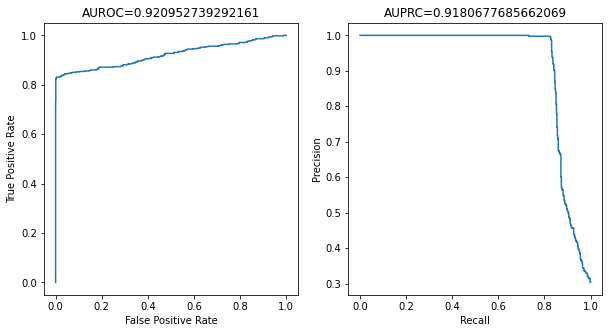

{'dataset_num_samples': 1730,
 'dataset_num_errors': 521,
 'auroc': 0.920952739292161,
 'auprc': 0.9180677685662069,
 'precision': array([0.30343623, 0.3030303 , 0.303207  , ..., 1.        , 1.        ,
        1.        ]),
 'recall': array([1.        , 0.99808061, 0.99808061, ..., 0.11132438, 0.05566219,
        0.        ]),
 'thresholds': array([1.8119812e-05, 1.8477440e-05, 1.8715858e-05, ..., 9.9999988e-01,
        9.9999994e-01, 1.0000000e+00], dtype=float32),
 'lift_at_num_errors': 2.8170394302997708,
 'lift_at_100': 3.320537428023033}

In [35]:
compute_metrics(rank_with_error,np.array(has_error))